In [7]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt

use roi annotation masks in \\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_v2_021723
to crop and rotate dlmaks in \\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined
save them with their original image name tagged with section ID to identify each pieces with in the same WSI
save DLcrop in \\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\DLcrop
read DLcrop and post-process and save in \\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\DLcrop_modified

In [8]:
#src = r'\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined'
roi_src = r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_v2_021723'
src = r'\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined'
imlist = glob.glob(os.path.join(src,'*.tif'))
imlist = natsorted(imlist)
#imlist=imlist[0:5]

\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\DLcrop
section N:  1 / 1
58 sec elapsed for part A
5 sec elapsed for part B
0 sec elapsed for part C
0 sec elapsed for part D
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\DLcrop
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\DLcrop
section N:  1 / 1
173 sec elapsed for part A
12 sec elapsed for part B
0 sec elapsed for part C
0 sec elapsed for part D
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\DLcrop
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined
\\shelter\Kyu\skin_aging\clue_cohort\HE1um\classification_v9_combined\DLcrop


ValueError: operands could not be broadcast together with shapes (19275,40696) (19275,40697) 

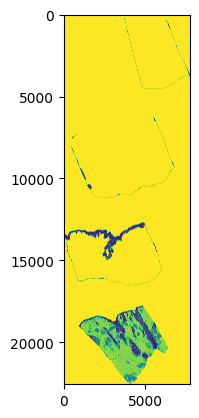

In [9]:
df=[]
for imname in imlist:
    minTA = 20000
    minTAhole = 100
    minDermhole = 5000
    minepisize=1000
    whitespace=12
    #src = os.path.dirname(imname)
    print(src)
    dst = os.path.join(src, 'DLcrop')
    print(dst)
    if not os.path.exists(dst):
        os.mkdir(dst)
    fn, ext = os.path.splitext(os.path.basename(imname))
    if os.path.exists(os.path.join(dst, '{}_sec{:02d}.png'.format(fn, 4))):
        print('continue')
        continue
    # open image
    im = Image.open(imname)

    #start:code on roi
    roi_nm = os.path.basename(imname)
    roi_nm = roi_nm.replace(".tif", ".png" )

    roi_pth = os.path.join(roi_src,roi_nm)
    if not os.path.exists(roi_pth):
        print("no roi found")
        continue

    roi = Image.open(roi_pth)

    TAbig = np.array(im) #original code
    TAbig = TAbig * np.array(roi).astype(bool) #maks  image with roi?
    #end: code on roi

    # downsize to expedite
    (width, height) = (im.width // 10, im.height // 10)
    im_resized = im.resize((width, height), resample=0)
    roi_resized = roi.resize((width, height), resample=0)

    TA = np.array(im_resized)
    TA = TA * roi_resized #ashley added for roi

    sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec
    sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
    sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole / 100).astype(np.uint8)  # 7sec
    # define background
    bw = closing(TA < whitespace, square(3))  # 12 is background
    bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
    bw = remove_small_holes(bw, area_threshold=minTAhole)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    # define middleground
    unknown = cv2.subtract(sure_bg, sure_fg).astype(bool)
    # label that background is 1 and objects are 2~N and middleground is zero
    sure_fg_label = label(sure_fg).astype(np.int32)
    sure_fg_label = sure_fg_label + 1
    sure_fg_label[unknown] = 0


    # perform watershed based on the marker
    TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR)
    label_image = cv2.watershed(TAbgr, sure_fg_label)
    # iterate each section
    epi = (TA == 1) | (TA == 2)
    derm = (2 < TA) & (TA < whitespace)
    derm = remove_small_holes(derm, area_threshold=minDermhole)
    epi2 = epi & ~derm
    epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)

    #should i use roi or just continue with the original code with label image
    numsecmax = np.max(label_image)

    # we iterate through ROI
    for numsec in range(1,numsecmax):
        print('section N: ', numsec, '/', numsecmax-1)
        msktmp = label_image == numsec+1 #replace watershed mask with ROI mask

        #find centroid
        stats = regionprops(msktmp.astype(np.uint8))
        centroid = stats[0].centroid #NOTE:this returns (y,x)!!
        cent = (round(10*centroid[1]),round(10*centroid[0])) #resize back to the origin image size, flip to (x,y)

        # mskderm = msktmp & derm
        mskepi = msktmp & epi2
        # align horizontal
        [xt2, yt2] = np.where(mskepi)
        vertices = np.array([xt2[::10], yt2[::10]]).T
        vc = vertices - vertices.mean(axis=0)
        U, S, Vt = np.linalg.svd(vc)
        k = Vt.T

        d0 = degrees(atan2(k[1, 1], k[1, 0]))  # arctan of sin/cos in degrees
        d0special = False
        if np.linalg.det(k) < 0:
            d0special = True
            d0 = -d0
        if d0 < 0: d0 = d0 + 360

        TAtmp = deepcopy(TAbig).astype('float32') #float64 is too big, could we use float32 instead?
        mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
        kernel = np.ones((20, 20), np.uint8)
        mskbig = cv2.dilate(mskbig, kernel, iterations=3)
        TAtmp[mskbig == 0] = 0 #scale back up to perform rotation #1sec

        start = time() # 10sec
        # degrot = np.abs(d0 - 90) # TO-DO: confirm if this is true.
        degrot = round(d0) #

        mskrot = rotate(TAtmp, degrot, resize=True, preserve_range=True, order=0)  # this is slow
        #can I expedite by not preserving range and recovering original pixel later?
        print(round(time() - start), 'sec elapsed for part A')

        start = time() #
        [xt, yt] = np.where(mskrot) # mskrot is sometimes not detected
        [xt2, yt2] = np.where((mskrot == 1) | (mskrot == 2))
        mskrot2 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
        print(round(time() - start), 'sec elapsed for part B')
        start = time()  #
        if np.mean(xt) - np.mean(xt2) < 0:  # if dermis is above epidermis, flip it
            mskrot2 = np.rot90(np.rot90(mskrot2))
        print(round(time() - start), 'sec elapsed for part C')
        start = time()  #
        mskrot2[mskrot2 == 0] = whitespace  # assign whitespace value to background
        print(round(time() - start), 'sec elapsed for part D')

        plt.imshow(mskrot2)


        #save
        Image.fromarray(mskrot2.astype('int8')).save(
            os.path.join(dst, '{}_sec{:02d}.png'.format(fn, numsec)))
        print(dst)

        #add to dataframe
        df.append({'imname': fn, 'secN': numsec, 'secCent': cent,'degrot': degrot}) #?
        df2 = pd.DataFrame(df)
        df2.to_csv('CLUEdegrot.csv')

In [ ]:
plt.imshow(TAbig)

In [55]:
im.size, roi.size

((21196, 21140), (21196, 21140))

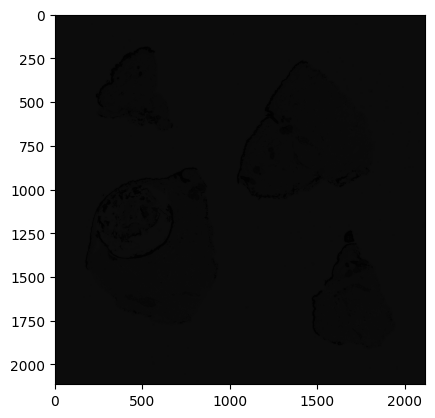

In [53]:
plt.imshow(TAbgr)